In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 74.8 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


Epoch 10/100, Loss: 0.0000
Epoch 20/100, Loss: 0.0000
Epoch 30/100, Loss: 0.0000
Epoch 40/100, Loss: 0.0000
Epoch 50/100, Loss: 0.0000
Epoch 60/100, Loss: 0.0000
Epoch 70/100, Loss: 0.0000
Epoch 80/100, Loss: 0.0000
Epoch 90/100, Loss: 0.0000
Epoch 100/100, Loss: 0.0000


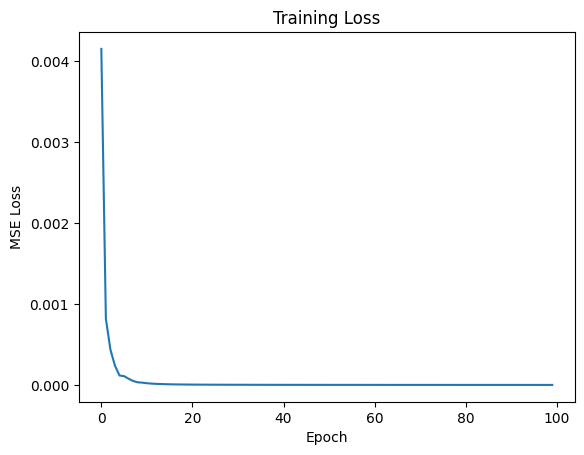

Average Overlap with |00...0> state: 0.9999
First predicted state vector:
tensor([ 1.0000e+00+3.5287e-04j,  1.1176e-08+8.8419e-09j,
         4.3362e-09+4.8320e-08j, -1.8911e-07+1.6895e-08j,
        -1.9190e-07+6.3462e-08j, -1.6605e-04-4.4545e-05j,
         3.6448e-08+6.0707e-08j, -1.6450e-04+2.8801e-05j,
         4.3063e-08+1.4453e-09j, -2.8228e-04+1.0194e-04j,
        -4.2350e-04+1.3545e-04j, -2.3002e-05-1.0776e-04j,
        -3.5440e-08-1.2436e-08j, -1.8288e-04+1.3508e-04j,
         2.4134e-04+1.0594e-04j, -3.8816e-05-1.4832e-04j],
       dtype=torch.complex128)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
# Config
num_qubits = 4
num_pqc_layers = 2
input_dim = 8
num_data_points = 100
batch_size = 25
learning_rate = 0.01
num_epochs = 100
device = "cuda" if torch.cuda.is_available() else "cpu"

# Data
def create_normal_data(num_samples, features):
    data = torch.randn(num_samples, features, device=device)
    return data

# MLP
class ParameterPredictor(nn.Module):
    def __init__(self, input_size, qubits, layers):
        super().__init__()
        num_params = layers * qubits * 3
        self.layers = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, num_params)
        )

    def forward(self, x):
        return self.layers(x)

# PQC
quantum_dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(quantum_dev, interface="torch")
def quantum_circuit(params):
    params = params.reshape(num_pqc_layers, num_qubits, 3)
    for layer in range(num_pqc_layers):
        for qubit in range(num_qubits):
            qml.RX(params[layer, qubit, 0], wires=qubit)
            qml.RY(params[layer, qubit, 1], wires=qubit)
            qml.RZ(params[layer, qubit, 2], wires=qubit)
        for qubit in range(num_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        if num_qubits > 1:
            qml.CNOT(wires=[num_qubits - 1, 0])
    return qml.state()

# Loss
def state_mse_loss(predicted, target):
    if predicted.dtype != torch.complex64:
        predicted = predicted.to(torch.complex64)
    if target.dtype != torch.complex64:
        target = target.to(torch.complex64)
    return torch.mean(torch.abs(predicted - target) ** 2)

# Train
def train_model():
    model = ParameterPredictor(input_dim, num_qubits, num_pqc_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    data = create_normal_data(num_data_points, input_dim)
    loss_history = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i in range(0, num_data_points, batch_size):
            batch_data = data[i:i + batch_size]
            optimizer.zero_grad()
            predicted_params = model(batch_data)
            batch_predicted_states = torch.stack([quantum_circuit(predicted_params[j]) for j in range(batch_data.shape[0])])
            target_state = torch.zeros(2**num_qubits, dtype=torch.complex64, device=device)
            target_state[0] = 1.0
            batch_target_states = target_state.repeat(batch_data.shape[0], 1)
            loss = state_mse_loss(batch_predicted_states, batch_target_states)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        avg_loss = epoch_loss / (num_data_points // batch_size)
        loss_history.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    plt.plot(loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training Loss")
    plt.show()
    return model

# Main
if __name__ == "__main__":
    trained_model = train_model()
    test_data = create_normal_data(10, input_dim)
    with torch.no_grad():
        predicted_params = trained_model(test_data)
    predicted_states = [quantum_circuit(predicted_params[i]) for i in range(test_data.shape[0])]
    target_state = torch.zeros(2**num_qubits, dtype=torch.complex64, device=device)
    target_state[0] = 1.0
    overlaps = [torch.abs(torch.dot(target_state.conj().to(torch.complex64), state.to(torch.complex64)))**2 for state in predicted_states]
    print(f"Average Overlap with |00...0> state: {np.mean(overlaps):.4f}")
    print("First predicted state vector:")
    print(predicted_states[0])